In [1]:
# Install packages
!pip install yfinance pandas matplotlib seaborn streamlit riskfolio-lib

# Install libraries
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

try:
    import riskfolio.Portfolio as pf
    riskfolio_available = True
except ImportError:
    riskfolio_available = False

Configuration of Tickers & Dates

In [2]:
# Define a dictionary of tickers (name → ticker symbol)
tickers = {
    "Apple": "AAPL",
    "Tesla": "TSLA",
    "Microsoft": "MSFT",
    "Amazon": "AMZN",
    "NVIDIA": "NVDA"
}

start_date = "2020-01-01"
end_date = "2025-01-01"


Data Download

In [3]:
data = {}
for name, ticker in tickers.items():
    print(f"📥 Downloading {name} ({ticker})...")
    stock = yf.download(ticker, start=start_date, end=end_date, group_by="column")

    if not stock.empty:
        if "Adj Close" in stock.columns:
            data[name] = stock["Adj Close"].squeeze()
        elif "Close" in stock.columns:
            print(f"⚠️ {ticker} missing 'Adj Close'. Using 'Close' instead.")
            data[name] = stock["Close"].squeeze()
        else:
            print(f"❌ {ticker} has no valid price columns.")
    else:
        print(f"❌ No data returned for {ticker}")


📥 Downloading Apple (AAPL)...
YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


⚠️ AAPL missing 'Adj Close'. Using 'Close' instead.
📥 Downloading Tesla (TSLA)...
⚠️ TSLA missing 'Adj Close'. Using 'Close' instead.
📥 Downloading Microsoft (MSFT)...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


⚠️ MSFT missing 'Adj Close'. Using 'Close' instead.
📥 Downloading Amazon (AMZN)...
⚠️ AMZN missing 'Adj Close'. Using 'Close' instead.
📥 Downloading NVIDIA (NVDA)...


[*********************100%***********************]  1 of 1 completed

⚠️ NVDA missing 'Adj Close'. Using 'Close' instead.


Dataframe formation

,Apple,Tesla,Microsoft,Amazon,NVIDIA
Date,,,,,
2024-12-24,257.578674,462.279999,437.647369,229.050003,140.207108
2024-12-26,258.396667,454.130005,436.432068,227.050003,139.917130
2024-12-27,254.974930,431.660004,428.881104,223.750000,136.997391
2024-12-30,251.593094,417.410004,423.202911,221.300003,137.477356
2024-12-31,249.817383,403.839996,419.885681,219.389999,134.277649


C:\Users\genin\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128279 (\N{LINK SYMBOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


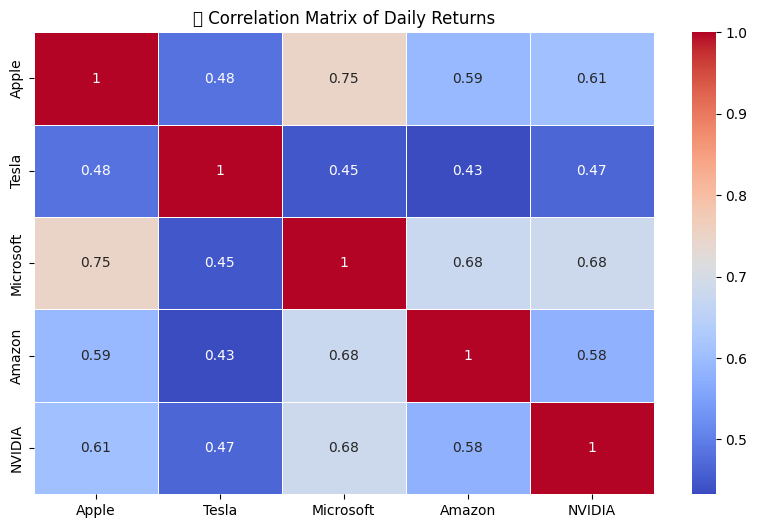

C:\Users\genin\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128257 (\N{CLOCKWISE RIGHTWARDS AND LEFTWARDS OPEN CIRCLE ARROWS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


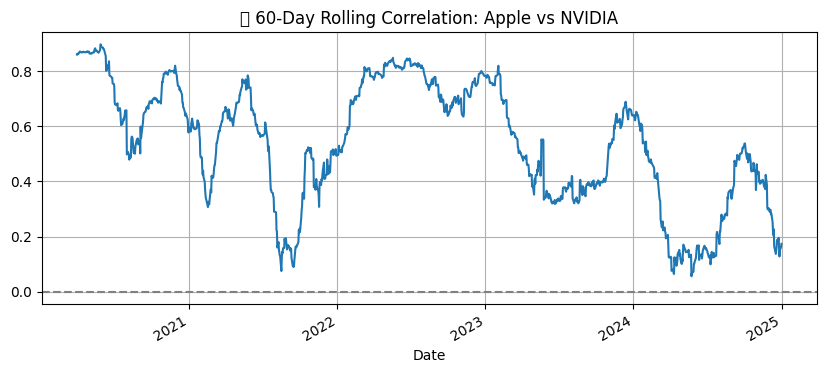

⚠️ Install riskfolio-lib to enable risk metrics and optimization.


In [4]:
# Combine into a single wide-format DataFrame
if len(data) == 0:
    print("❌ No valid data downloaded.")
else:
    price_df = pd.DataFrame(data).dropna()
    price_df.to_csv("prices.csv") # Save backup to disk
    display(price_df.tail())

    # RETURN CALCULATION
    # Calculate daily returns from price history
    returns = price_df.pct_change().dropna()

    # CORRELATION MATRIX
    # Calculate and visualize the correlation matrix of returns
    corr_matrix = returns.corr()
    plt.figure(figsize=(10, 6))
    sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
    plt.title("🔗 Correlation Matrix of Daily Returns")
    plt.show()

    # ROLLING CORRELATION
    # 60-day rolling correlation between Apple and NVIDIA
    if "Apple" in returns.columns and "NVIDIA" in returns.columns:
        roll_corr = returns["Apple"].rolling(60).corr(returns["NVIDIA"])
        roll_corr.plot(title="🔁 60-Day Rolling Correlation: Apple vs NVIDIA", figsize=(10, 4))
        plt.axhline(0, color='gray', linestyle='--')
        plt.grid(True)
        plt.show()

    # RISK METRICS AND OPTIMIZATION (IF AVAILABLE)
    if riskfolio_available:
        # Initialize portfolio object with returns
        port = pf.Portfolio(returns=returns)

        # Estimate expected returns and covariances
        port.assets_stats(method_mu='hist', method_cov='hist')

        # Calculate risk measures
        risk = port.risk_measures(method='hist', rf=0)
        display(risk[["VaR_0.05", "CVaR_0.05", "Sharpe"]].round(4))

        # PORTFOLIO OPTIMIZATION
        # Maximize Sharpe ratio using historical return and variance
        w = port.optimization(model="Classic", rm="MV", obj="Sharpe", hist=True)
        display(w.T.round(4))

        # PERFORMANCE TRACKING
        # Compute cumulative return for the optimized portfolio
        port_weights = w[w > 0].index.tolist()
        weighted_returns = returns[port_weights].mul(w.T[port_weights].values, axis=1).sum(axis=1)
        cumulative_returns = (1 + weighted_returns).cumprod()
        cumulative_returns.plot(title="📈 Optimized Portfolio Cumulative Returns", figsize=(10, 4))
        plt.grid(True)
        plt.show()

        # DRAWDOWN CHART
        drawdown = (cumulative_returns - cumulative_returns.cummax()) / cumulative_returns.cummax()
        drawdown.plot(title="📉 Drawdown from Peak", figsize=(10, 4), color="red")
        plt.grid(True)
        plt.show()

        # REBALANCING SIMULATION
        rebalance_returns = weighted_returns.resample('M').apply(lambda x: (1 + x).prod() - 1)
        rebalance_cumulative = (1 + rebalance_returns).cumprod()
        rebalance_cumulative.plot(title="🔁 Monthly Rebalanced Portfolio", figsize=(10, 4))
        plt.grid(True)
        plt.show()
    else:
        print("⚠️ Install riskfolio-lib to enable risk metrics and optimization.")